In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, mixture
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

In [2]:
def create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey):
    mean = model(true_theta)
    samples = jax.random.multivariate_normal(key=prngkey, mean=mean, cov=noise_cov, shape=(num_samples,))
    return samples.reshape(num_samples, -1)

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
# Create artificial data:
prngkey = jax.random.PRNGKey(10)
true_theta = jnp.array([2])
noise_cov = 0.1*jnp.identity(ndim)
num_samples = 1
data = create_data(model, true_theta, noise_cov, num_samples, ndim, prngkey)
print(f'True theta: \n {true_theta}')
print(f'True x = model(theta): \n {model(true_theta)}')
print(f'Observations x_obs = model(theta) + noise: \n {data}')

True theta: 
 [2]
True x = model(theta): 
 [4]
Observations x_obs = model(theta) + noise: 
 [[3.5748188]]


In [5]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = 1.0*jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [6]:
approx_dist = approx.Gaussian(ndim)
prngkey = jax.random.PRNGKey(12)
loss = losses.ELBO(joint_dist, use_reparameterisation=False)
optimiser = optimisers.Adam()
optimiser.fit(approx_dist, loss, data, prngkey, verbose = True, max_iter=100, num_samples=1000)

Loss = 42.32734680175781, Params = Jaxtainer({'mean': DeviceArray([-0.1], dtype=float32), 'log_chol_diag': DeviceArray([-0.1], dtype=float32)})
Loss = 42.76001739501953, Params = Jaxtainer({'mean': DeviceArray([-0.19902016], dtype=float32), 'log_chol_diag': DeviceArray([-0.03817664], dtype=float32)})


KeyboardInterrupt: 

In [8]:
mix_dist.components.keys()

dict_keys(['component_0', 'component_1'])

In [14]:
A.params

Jaxtainer({'mean': array([0.], dtype=float32), 'log_chol_diag': array([0.], dtype=float32)})

In [13]:
import copy
A = copy.deepcopy(approx_dist)

In [6]:
approx_dist = approx.Gaussian(ndim)
mix_dist = mixture.Different([approx_dist, approx_dist])
perturbation = {'component_0': -0.5, 'component_1': 0.5, 'log_unnorm_coeff': jnp.array([-0.1, 0.1])}
mix_dist.perturb(perturbation)
mix_dist.phi()

Jaxtainer({'mean': DeviceArray([-0.5], dtype=float32), 'log_chol_diag': DeviceArray([-0.5], dtype=float32)})
Jaxtainer({'mean': DeviceArray([0.], dtype=float32), 'log_chol_diag': DeviceArray([0.], dtype=float32)})


Jaxtainer({'component_0': {'mean': DeviceArray([[0.]], dtype=float32), 'log_chol_diag': DeviceArray([[0.]], dtype=float32)}, 'component_1': {'mean': DeviceArray([[0.]], dtype=float32), 'log_chol_diag': DeviceArray([[0.]], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([[-0.1,  0.1]], dtype=float32)})

In [11]:
approx_dist = approx.Gaussian(ndim)
mix_dist = mixture.Different([approx_dist, approx_dist])
# mix_dist = mixture.Identical(approx_dist,2)

perturbation = {'component_0': -0.5, 'component_1': 0.5, 'log_unnorm_coeff': jnp.array([-0.1, 0.1])}
mix_dist.perturb(perturbation)

prngkey = jax.random.PRNGKey(12)
loss = losses.ELBO(joint_dist, use_reparameterisation=False)
optimiser = optimisers.Adam()
optimiser.fit(mix_dist, loss, data, prngkey, verbose = True, max_iter=100, num_samples=1000)

Loss = 44.025577545166016, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-0.09999999], dtype=float32), 'log_chol_diag': DeviceArray([0.1], dtype=float32)}, 'component_1': {'mean': DeviceArray([-0.09999999], dtype=float32), 'log_chol_diag': DeviceArray([0.1], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-0.1986363 ,  0.19861846], dtype=float32)})
Loss = 42.305137634277344, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-0.03263712], dtype=float32), 'log_chol_diag': DeviceArray([0.05789034], dtype=float32)}, 'component_1': {'mean': DeviceArray([-0.0313299], dtype=float32), 'log_chol_diag': DeviceArray([0.05195417], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-0.2955305 ,  0.16693321], dtype=float32)})
Loss = 41.989784240722656, Params = Jaxtainer({'component_0': {'mean': DeviceArray([0.0070596], dtype=float32), 'log_chol_diag': DeviceArray([0.05882956], dtype=float32)}, 'component_1': {'mean': DeviceArray([0.00706816], dtype=float32), 'log_chol_diag': Devi

Loss = 43.851314544677734, Params = Jaxtainer({'component_0': {'mean': DeviceArray([0.48909408], dtype=float32), 'log_chol_diag': DeviceArray([-0.08619151], dtype=float32)}, 'component_1': {'mean': DeviceArray([0.48507786], dtype=float32), 'log_chol_diag': DeviceArray([-0.09635086], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-1.1747462 ,  0.18205507], dtype=float32)})
Loss = 41.80685043334961, Params = Jaxtainer({'component_0': {'mean': DeviceArray([0.5008675], dtype=float32), 'log_chol_diag': DeviceArray([-0.12399486], dtype=float32)}, 'component_1': {'mean': DeviceArray([0.5018903], dtype=float32), 'log_chol_diag': DeviceArray([-0.13240509], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-1.1844705 ,  0.19210339], dtype=float32)})
Loss = 41.325889587402344, Params = Jaxtainer({'component_0': {'mean': DeviceArray([0.53055567], dtype=float32), 'log_chol_diag': DeviceArray([-0.15217277], dtype=float32)}, 'component_1': {'mean': DeviceArray([0.53776807], dtype=float32), 'log_ch

Loss = 8.348271369934082, Params = Jaxtainer({'component_0': {'mean': DeviceArray([1.8336442], dtype=float32), 'log_chol_diag': DeviceArray([-1.340775], dtype=float32)}, 'component_1': {'mean': DeviceArray([1.8358036], dtype=float32), 'log_chol_diag': DeviceArray([-1.3534496], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-1.1547076 ,  0.21820234], dtype=float32)})
Loss = 7.069656848907471, Params = Jaxtainer({'component_0': {'mean': DeviceArray([1.8390467], dtype=float32), 'log_chol_diag': DeviceArray([-1.4284414], dtype=float32)}, 'component_1': {'mean': DeviceArray([1.8405248], dtype=float32), 'log_chol_diag': DeviceArray([-1.440506], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-1.1601729 ,  0.21740611], dtype=float32)})
Loss = 6.197473049163818, Params = Jaxtainer({'component_0': {'mean': DeviceArray([1.8396406], dtype=float32), 'log_chol_diag': DeviceArray([-1.5108063], dtype=float32)}, 'component_1': {'mean': DeviceArray([1.8404684], dtype=float32), 'log_chol_diag': Dev

KeyboardInterrupt: 

In [50]:
mix_dist.add_component()

In [51]:
def filter(grad):
    for i in range(2):
        grad[f'component_{i}'] = 0*grad[f'component_{i}']
    grad['log_unnorm_coeff'] = 0*grad['log_unnorm_coeff']
    return grad

optimiser.fit(mix_dist, loss, data, prngkey, grad_filter=filter, verbose = True, max_iter=100, num_samples=1000)

Loss = 16.963205337524414, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([0.1], dtype=float32), 'log_chol_diag': DeviceArray([-0.1], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 17.048307418823242, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([0.19720927], dtype=float32), 'log_chol_diag': DeviceArray([-0.0631719], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 77.3374252319336, Params = Jaxtain

Loss = 16.196279525756836, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([0.95128405], dtype=float32), 'log_chol_diag': DeviceArray([0.07320705], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 15.72618293762207, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([0.93747157], dtype=float32), 'log_chol_diag': DeviceArray([0.04826734], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 15.328091621398926, Pa

Loss = 12.380037307739258, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.5377898], dtype=float32), 'log_chol_diag': DeviceArray([-0.27507815], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 12.327363967895508, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.5806605], dtype=float32), 'log_chol_diag': DeviceArray([-0.3060251], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 12.020938873291016, Pa

Loss = 6.256175994873047, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.8365232], dtype=float32), 'log_chol_diag': DeviceArray([-0.9398661], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 6.065823554992676, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8736784], dtype=float32), 'log_chol_diag': DeviceArray([-2.84708], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.9084057], dtype=float32), 'log_chol_diag': DeviceArray([-2.3000681], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.848017], dtype=float32), 'log_chol_diag': DeviceArray([-0.9781812], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([0., 0., 0.], dtype=float32)})
Loss = 5.871151924133301, Params 

KeyboardInterrupt: 

In [61]:
optimiser.fit(mix_dist, loss, data, prngkey, verbose = True, max_iter=100, num_samples=1000)

Loss = 3.3678321838378906, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8323203], dtype=float32), 'log_chol_diag': DeviceArray([-2.5328481], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.7339813], dtype=float32), 'log_chol_diag': DeviceArray([-2.5893712], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.9862292], dtype=float32), 'log_chol_diag': DeviceArray([-2.4281693], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-0.3652572 , -1.3720236 ,  0.45408142], dtype=float32)})
Loss = 4.05007791519165, Params = Jaxtainer({'component_0': {'mean': DeviceArray([-1.8997691], dtype=float32), 'log_chol_diag': DeviceArray([-2.504057], dtype=float32)}, 'component_1': {'mean': DeviceArray([-1.7494128], dtype=float32), 'log_chol_diag': DeviceArray([-2.5012026], dtype=float32)}, 'component_2': {'mean': DeviceArray([1.9404514], dtype=float32), 'log_chol_diag': DeviceArray([-2.3289673], dtype=float32)}, 'log_unnorm_coeff': DeviceArray([-0.30662692, -1.3953787 ,  0.383

KeyboardInterrupt: 

In [9]:
def plot_posteriors(approx_dist, theta=None):
    if theta is None:
        theta = jnp.atleast_2d(jnp.linspace(-3, 3, 1000)).reshape(1,-1,1)
    pdf = jnp.exp(approx_dist.logpdf(theta))
    ax = sns.lineplot(x=theta.squeeze(), y=pdf.squeeze())
    ax.fill_between(theta.squeeze(), pdf.squeeze(), alpha=0.2)
    plt.xlabel("Parameter $\Theta$")
    plt.ylabel("Posterior Probability Density")

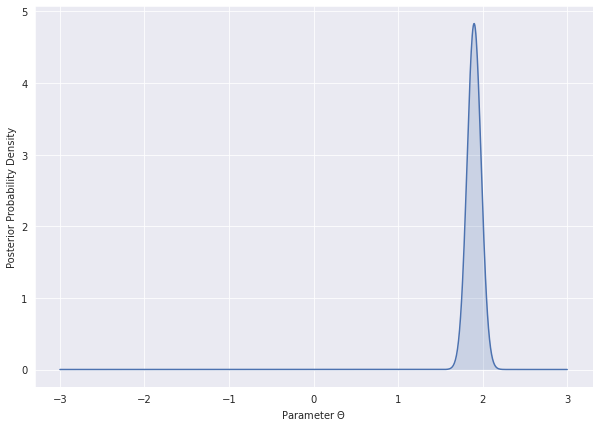

In [10]:
plot_posteriors(mix_dist)

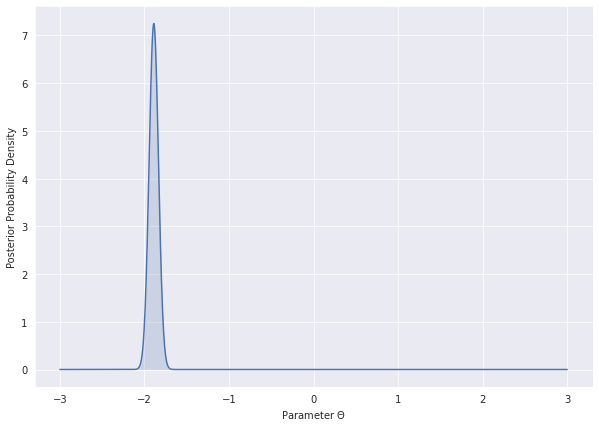

In [19]:
plot_posteriors(approx_dist)